# LIBRARIES REQUIRED

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier as rcf
from sklearn.tree import DecisionTreeClassifier as dct
from sklearn.model_selection import cross_val_score
#from lightgbm import LGBMClassifier as lgb
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from catboost import CatBoostClassifier, Pool
import category_encoders as ce

C:\Users\Who are you\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
SEED = 1972

In [3]:
train = pd.read_csv('F:/Data Science/Jobathon-Credit Card Lead Prediction/train_s3TEQDk.csv')
test = pd.read_csv('F:/Data Science/Jobathon-Credit Card Lead Prediction/test_mSzZ8RL.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


# MISSING VALUES AND TREATMENT

In [5]:
train.isna().sum()
train.isnull().sum() / len(train)

ID                     0.000000
Gender                 0.000000
Age                    0.000000
Region_Code            0.000000
Occupation             0.000000
Channel_Code           0.000000
Vintage                0.000000
Credit_Product         0.119341
Avg_Account_Balance    0.000000
Is_Active              0.000000
Is_Lead                0.000000
dtype: float64

G:\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Credit_Product', ylabel='count'>

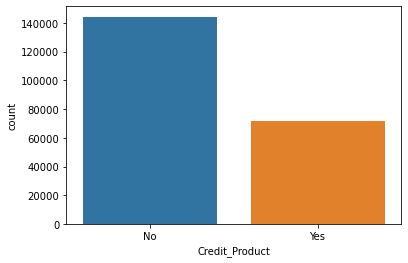

In [6]:
sns.countplot(train['Credit_Product'])

Outliers capping

In [7]:
print(train["Avg_Account_Balance"].quantile(0.95))

2673533.0


In [8]:
train["Avg_Account_Balance"].clip(upper = 2673533,inplace = True)
train['Credit_Product'] = train['Credit_Product'].map({'No' : 0, 'Yes' : 1})

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   245725 non-null  object 
 1   Gender               245725 non-null  object 
 2   Age                  245725 non-null  int64  
 3   Region_Code          245725 non-null  object 
 4   Occupation           245725 non-null  object 
 5   Channel_Code         245725 non-null  object 
 6   Vintage              245725 non-null  int64  
 7   Credit_Product       216400 non-null  float64
 8   Avg_Account_Balance  245725 non-null  int64  
 9   Is_Active            245725 non-null  object 
 10  Is_Lead              245725 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 20.6+ MB


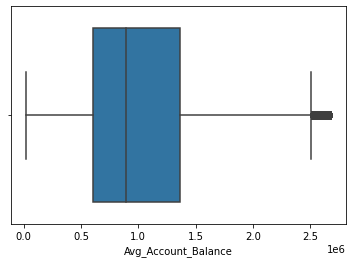

In [9]:
ax = sns.boxplot(x=train["Avg_Account_Balance"])

In [12]:
# dropping useless columns 
df = train.drop(columns = ['ID'], axis = 'columns')
df.head()

# Encoding categorical variables

df['Occupation'] = df['Occupation'].map({'Self_Employed' : 0, 'Salaried' : 1, 'Other' : 2, 'Entrepreneur':3})
df['Gender'] = df['Gender'].map({'Male' : 0, 'Female' : 1})
df['Channel_Code'] = df['Channel_Code'].map({'X1' : 0, 'X3' : 1, 'X2' : 2, 'X4':3})

df['Is_Active'] = df['Is_Active'].map({'No' : 0, 'Yes' : 1})

In [13]:
encoder= ce.BinaryEncoder(cols=['Region_Code'],return_df=True)
df=encoder.fit_transform(df) 
df.head()

G:\Anaconda3\envs\tensorflow\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Gender,Age,Region_Code_0,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,1,73,0,0,0,0,0,0,1,2,1,43,0.0,1045696,0,0
1,1,30,0,0,0,0,0,1,0,1,0,32,0.0,581988,0,0
2,1,56,0,0,0,0,0,0,1,0,1,26,0.0,1484315,1,0
3,0,34,0,0,0,0,0,1,1,1,0,19,0.0,470454,0,0
4,1,30,0,0,0,0,1,0,0,1,0,33,0.0,886787,0,0


In [14]:
train1 = df[df.Credit_Product.notnull()]
test1 = df[df.Credit_Product.isnull()]

In [15]:
X_train1 = train1.drop(["Credit_Product"],axis=1)
Y_train1 = train1["Credit_Product"]

X_test1 = test1.drop(["Credit_Product"], axis=1)# ytest need to be predicted

In [16]:
from sklearn.tree import DecisionTreeClassifier
dct=DecisionTreeClassifier()
dct.fit(X_train1, Y_train1)


DecisionTreeClassifier()

In [17]:
Y_pred1 = dct.predict(X_test1)

len(Y_pred1)

29325

In [18]:
df.isnull().sum()

Gender                     0
Age                        0
Region_Code_0              0
Region_Code_1              0
Region_Code_2              0
Region_Code_3              0
Region_Code_4              0
Region_Code_5              0
Region_Code_6              0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [19]:
df.Credit_Product[df.Credit_Product.isnull()] = Y_pred1

G:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
df.isnull().sum()

Gender                 0
Age                    0
Region_Code_0          0
Region_Code_1          0
Region_Code_2          0
Region_Code_3          0
Region_Code_4          0
Region_Code_5          0
Region_Code_6          0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               245725 non-null  int64  
 1   Age                  245725 non-null  int64  
 2   Region_Code_0        245725 non-null  int64  
 3   Region_Code_1        245725 non-null  int64  
 4   Region_Code_2        245725 non-null  int64  
 5   Region_Code_3        245725 non-null  int64  
 6   Region_Code_4        245725 non-null  int64  
 7   Region_Code_5        245725 non-null  int64  
 8   Region_Code_6        245725 non-null  int64  
 9   Occupation           245725 non-null  int64  
 10  Channel_Code         245725 non-null  int64  
 11  Vintage              245725 non-null  int64  
 12  Credit_Product       245725 non-null  float64
 13  Avg_Account_Balance  245725 non-null  int64  
 14  Is_Active            245725 non-null  int64  
 15  Is_Lead          

In [22]:
test['Credit_Product'] = test['Credit_Product'].map({'No' : 0, 'Yes' : 1})

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   105312 non-null  object 
 1   Gender               105312 non-null  object 
 2   Age                  105312 non-null  int64  
 3   Region_Code          105312 non-null  object 
 4   Occupation           105312 non-null  object 
 5   Channel_Code         105312 non-null  object 
 6   Vintage              105312 non-null  int64  
 7   Credit_Product       92790 non-null   float64
 8   Avg_Account_Balance  105312 non-null  int64  
 9   Is_Active            105312 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 8.0+ MB


In [24]:
df2 = test.drop(columns = ['ID'], axis = 'columns')
df2.head()

# Encoding categorical variables

df2['Occupation'] = df2['Occupation'].map({'Self_Employed' : 0, 'Salaried' : 1, 'Other' : 2, 'Entrepreneur':3})
df2['Gender'] = df2['Gender'].map({'Male' : 0, 'Female' : 1})
df2['Channel_Code'] = df2['Channel_Code'].map({'X1' : 0, 'X3' : 1, 'X2' : 2, 'X4':3})

df2['Is_Active'] = df2['Is_Active'].map({'No' : 0, 'Yes' : 1})


In [25]:
df2=encoder.fit_transform(df2) 
df2

G:\Anaconda3\envs\tensorflow\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Gender,Age,Region_Code_0,Region_Code_1,Region_Code_2,Region_Code_3,Region_Code_4,Region_Code_5,Region_Code_6,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,0,29,0,0,0,0,0,0,1,2,0,25,1.0,742366,0
1,0,43,0,0,0,0,0,1,0,2,2,49,NaN,925537,0
2,0,31,0,0,0,0,0,1,1,1,0,14,0.0,215949,0
3,0,29,0,0,0,0,1,0,0,2,0,33,0.0,868070,0
4,1,29,0,0,0,0,0,1,1,2,0,19,0.0,657087,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105307,0,52,0,0,0,0,0,1,0,1,2,86,1.0,4242558,1
105308,0,55,0,0,0,1,0,0,1,2,2,86,1.0,1159153,0
105309,0,35,0,0,0,0,0,0,1,1,3,15,0.0,1703727,0
105310,0,53,0,0,0,0,0,0,1,2,1,93,0.0,737178,1


In [26]:
train2 = df2[df2.Credit_Product.notnull()]
test2 = df2[df2.Credit_Product.isnull()]

In [27]:
X_train2 = train2.drop(["Credit_Product"],axis=1)
Y_train2 = train2["Credit_Product"]

In [28]:
X_test2 = test2.drop(["Credit_Product"], axis=1)# ytest need to be predicted

In [29]:
dct.fit(X_train2, Y_train2)
Y_pred2 = dct.predict(X_test2)

In [30]:
len(Y_pred2)


df2.Credit_Product[df2.Credit_Product.isnull()] = Y_pred2

G:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [31]:
df2.isnull().sum()

Gender                 0
Age                    0
Region_Code_0          0
Region_Code_1          0
Region_Code_2          0
Region_Code_3          0
Region_Code_4          0
Region_Code_5          0
Region_Code_6          0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
dtype: int64

In [32]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Gender               105312 non-null  int64  
 1   Age                  105312 non-null  int64  
 2   Region_Code_0        105312 non-null  int64  
 3   Region_Code_1        105312 non-null  int64  
 4   Region_Code_2        105312 non-null  int64  
 5   Region_Code_3        105312 non-null  int64  
 6   Region_Code_4        105312 non-null  int64  
 7   Region_Code_5        105312 non-null  int64  
 8   Region_Code_6        105312 non-null  int64  
 9   Occupation           105312 non-null  int64  
 10  Channel_Code         105312 non-null  int64  
 11  Vintage              105312 non-null  int64  
 12  Credit_Product       105312 non-null  float64
 13  Avg_Account_Balance  105312 non-null  int64  
 14  Is_Active            105312 non-null  int64  
dtypes: float64(1), in

In [33]:
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

In [34]:
train.Credit_Product[train.Credit_Product.isnull()] = Y_pred1

G:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
train.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   245725 non-null  object 
 1   Gender               245725 non-null  object 
 2   Age                  245725 non-null  int64  
 3   Region_Code          245725 non-null  object 
 4   Occupation           245725 non-null  object 
 5   Channel_Code         245725 non-null  object 
 6   Vintage              245725 non-null  int64  
 7   Credit_Product       245725 non-null  float64
 8   Avg_Account_Balance  245725 non-null  int64  
 9   Is_Active            245725 non-null  object 
 10  Is_Lead              245725 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 20.6+ MB


In [37]:
test.Credit_Product[test.Credit_Product.isnull()] = Y_pred2

G:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
test.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
dtype: int64

In [39]:
train['Credit_Product'] = train['Credit_Product'].astype(int)


In [40]:
test['Credit_Product'] = test['Credit_Product'].astype(int)

In [41]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   105312 non-null  object
 1   Gender               105312 non-null  object
 2   Age                  105312 non-null  int64 
 3   Region_Code          105312 non-null  object
 4   Occupation           105312 non-null  object
 5   Channel_Code         105312 non-null  object
 6   Vintage              105312 non-null  int64 
 7   Credit_Product       105312 non-null  int32 
 8   Avg_Account_Balance  105312 non-null  int64 
 9   Is_Active            105312 non-null  object
dtypes: int32(1), int64(3), object(6)
memory usage: 7.6+ MB


In [42]:
train.drop(columns ='ID',inplace=True)
test.drop(columns ='ID',inplace=True)

In [43]:
cat_columns = []
for col in train.select_dtypes('object').columns:
    print(col) 
    cat_columns.append(col)

Gender
Region_Code
Occupation
Channel_Code
Is_Active


In [44]:
Y= train["Is_Lead"]
X=train.drop(["Is_Lead"],axis=1)

X.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Avg_Account_Balance', 'Is_Active'],
      dtype='object')

In [45]:
cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index



[0, 2, 3, 4, 8]

In [48]:
#### MODEL 

#cate_features_index = np.where(trainset.dtypes != float)[0]
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, train_size=0.85,random_state=SEED)
from catboost import CatBoostClassifier


cat = CatBoostClassifier(eval_metric='Accuracy',
                         use_best_model=True,random_seed=SEED,learning_rate = 0.674 ,iterations = 700,depth = 6,
                         bagging_temperature=3,one_hot_max_size=2)

In [49]:
cat.fit(X1_train,y1_train ,cat_features=cat_features_index,eval_set=(X1_test,y1_test),use_best_model=True)

0:	learn: 0.8025193	test: 0.8008899	best: 0.8008899 (0)	total: 226ms	remaining: 2m 38s
1:	learn: 0.8092078	test: 0.8084321	best: 0.8084321 (1)	total: 427ms	remaining: 2m 28s
2:	learn: 0.8111181	test: 0.8132613	best: 0.8132613 (2)	total: 626ms	remaining: 2m 25s
3:	learn: 0.8128322	test: 0.8138582	best: 0.8138582 (3)	total: 840ms	remaining: 2m 26s
4:	learn: 0.8132583	test: 0.8142109	best: 0.8142109 (4)	total: 1.03s	remaining: 2m 23s
5:	learn: 0.8133061	test: 0.8139667	best: 0.8142109 (4)	total: 1.19s	remaining: 2m 17s
6:	learn: 0.8134641	test: 0.8135598	best: 0.8142109 (4)	total: 1.4s	remaining: 2m 18s
7:	learn: 0.8133205	test: 0.8136954	best: 0.8142109 (4)	total: 1.5s	remaining: 2m 9s
8:	learn: 0.8136604	test: 0.8138040	best: 0.8142109 (4)	total: 1.67s	remaining: 2m 8s
9:	learn: 0.8138041	test: 0.8136683	best: 0.8142109 (4)	total: 1.86s	remaining: 2m 8s
10:	learn: 0.8139046	test: 0.8138040	best: 0.8142109 (4)	total: 2.02s	remaining: 2m 6s
11:	learn: 0.8142206	test: 0.8141567	best: 0.814

95:	learn: 0.8194632	test: 0.8119862	best: 0.8146179 (14)	total: 18.9s	remaining: 1m 58s
96:	learn: 0.8194871	test: 0.8120405	best: 0.8146179 (14)	total: 19s	remaining: 1m 58s
97:	learn: 0.8195877	test: 0.8122033	best: 0.8146179 (14)	total: 19.2s	remaining: 1m 58s
98:	learn: 0.8198175	test: 0.8124203	best: 0.8146179 (14)	total: 19.4s	remaining: 1m 57s
99:	learn: 0.8197600	test: 0.8127187	best: 0.8146179 (14)	total: 19.6s	remaining: 1m 57s
100:	learn: 0.8197265	test: 0.8130172	best: 0.8146179 (14)	total: 19.8s	remaining: 1m 57s
101:	learn: 0.8198414	test: 0.8128001	best: 0.8146179 (14)	total: 20s	remaining: 1m 57s
102:	learn: 0.8198462	test: 0.8127459	best: 0.8146179 (14)	total: 20.2s	remaining: 1m 57s
103:	learn: 0.8200425	test: 0.8126102	best: 0.8146179 (14)	total: 20.4s	remaining: 1m 56s
104:	learn: 0.8200377	test: 0.8125560	best: 0.8146179 (14)	total: 20.6s	remaining: 1m 56s
105:	learn: 0.8200473	test: 0.8126102	best: 0.8146179 (14)	total: 20.8s	remaining: 1m 56s
106:	learn: 0.82021

188:	learn: 0.8236381	test: 0.8124746	best: 0.8146179 (14)	total: 37.8s	remaining: 1m 42s
189:	learn: 0.8236429	test: 0.8123660	best: 0.8146179 (14)	total: 37.9s	remaining: 1m 41s
190:	learn: 0.8237387	test: 0.8123932	best: 0.8146179 (14)	total: 38.2s	remaining: 1m 41s
191:	learn: 0.8238344	test: 0.8122033	best: 0.8146179 (14)	total: 38.4s	remaining: 1m 41s
192:	learn: 0.8237770	test: 0.8124746	best: 0.8146179 (14)	total: 38.5s	remaining: 1m 41s
193:	learn: 0.8237195	test: 0.8123932	best: 0.8146179 (14)	total: 38.7s	remaining: 1m 41s
194:	learn: 0.8237530	test: 0.8123389	best: 0.8146179 (14)	total: 38.9s	remaining: 1m 40s
195:	learn: 0.8238775	test: 0.8121219	best: 0.8146179 (14)	total: 39.1s	remaining: 1m 40s
196:	learn: 0.8238919	test: 0.8124746	best: 0.8146179 (14)	total: 39.3s	remaining: 1m 40s
197:	learn: 0.8239876	test: 0.8122575	best: 0.8146179 (14)	total: 39.5s	remaining: 1m 40s
198:	learn: 0.8239733	test: 0.8122847	best: 0.8146179 (14)	total: 39.7s	remaining: 1m 39s
199:	learn

280:	learn: 0.8270279	test: 0.8108196	best: 0.8146179 (14)	total: 56.5s	remaining: 1m 24s
281:	learn: 0.8270709	test: 0.8105754	best: 0.8146179 (14)	total: 56.7s	remaining: 1m 24s
282:	learn: 0.8271045	test: 0.8106297	best: 0.8146179 (14)	total: 56.9s	remaining: 1m 23s
283:	learn: 0.8271092	test: 0.8105212	best: 0.8146179 (14)	total: 57.1s	remaining: 1m 23s
284:	learn: 0.8270805	test: 0.8104669	best: 0.8146179 (14)	total: 57.3s	remaining: 1m 23s
285:	learn: 0.8272146	test: 0.8103584	best: 0.8146179 (14)	total: 57.5s	remaining: 1m 23s
286:	learn: 0.8272433	test: 0.8105212	best: 0.8146179 (14)	total: 57.7s	remaining: 1m 23s
287:	learn: 0.8272720	test: 0.8105483	best: 0.8146179 (14)	total: 57.9s	remaining: 1m 22s
288:	learn: 0.8272768	test: 0.8104398	best: 0.8146179 (14)	total: 58.1s	remaining: 1m 22s
289:	learn: 0.8272481	test: 0.8106297	best: 0.8146179 (14)	total: 58.4s	remaining: 1m 22s
290:	learn: 0.8272002	test: 0.8107925	best: 0.8146179 (14)	total: 58.5s	remaining: 1m 22s
291:	learn

373:	learn: 0.8304511	test: 0.8101413	best: 0.8146179 (14)	total: 1m 14s	remaining: 1m 5s
374:	learn: 0.8304798	test: 0.8103041	best: 0.8146179 (14)	total: 1m 15s	remaining: 1m 5s
375:	learn: 0.8305086	test: 0.8102227	best: 0.8146179 (14)	total: 1m 15s	remaining: 1m 4s
376:	learn: 0.8305277	test: 0.8102770	best: 0.8146179 (14)	total: 1m 15s	remaining: 1m 4s
377:	learn: 0.8305038	test: 0.8103041	best: 0.8146179 (14)	total: 1m 15s	remaining: 1m 4s
378:	learn: 0.8305421	test: 0.8101956	best: 0.8146179 (14)	total: 1m 15s	remaining: 1m 4s
379:	learn: 0.8305708	test: 0.8100871	best: 0.8146179 (14)	total: 1m 16s	remaining: 1m 4s
380:	learn: 0.8306426	test: 0.8099786	best: 0.8146179 (14)	total: 1m 16s	remaining: 1m 3s
381:	learn: 0.8307527	test: 0.8099243	best: 0.8146179 (14)	total: 1m 16s	remaining: 1m 3s
382:	learn: 0.8307575	test: 0.8097615	best: 0.8146179 (14)	total: 1m 16s	remaining: 1m 3s
383:	learn: 0.8307815	test: 0.8098972	best: 0.8146179 (14)	total: 1m 16s	remaining: 1m 3s
384:	learn

466:	learn: 0.8331466	test: 0.8094902	best: 0.8146179 (14)	total: 1m 33s	remaining: 46.5s
467:	learn: 0.8332663	test: 0.8094902	best: 0.8146179 (14)	total: 1m 33s	remaining: 46.4s
468:	learn: 0.8333333	test: 0.8094631	best: 0.8146179 (14)	total: 1m 33s	remaining: 46.2s
469:	learn: 0.8333860	test: 0.8093817	best: 0.8146179 (14)	total: 1m 33s	remaining: 46s
470:	learn: 0.8334051	test: 0.8093546	best: 0.8146179 (14)	total: 1m 34s	remaining: 45.7s
471:	learn: 0.8333764	test: 0.8092732	best: 0.8146179 (14)	total: 1m 34s	remaining: 45.6s
472:	learn: 0.8334770	test: 0.8093817	best: 0.8146179 (14)	total: 1m 34s	remaining: 45.4s
473:	learn: 0.8335440	test: 0.8091647	best: 0.8146179 (14)	total: 1m 34s	remaining: 45.2s
474:	learn: 0.8335201	test: 0.8092189	best: 0.8146179 (14)	total: 1m 34s	remaining: 45s
475:	learn: 0.8335201	test: 0.8090290	best: 0.8146179 (14)	total: 1m 35s	remaining: 44.8s
476:	learn: 0.8335248	test: 0.8090561	best: 0.8146179 (14)	total: 1m 35s	remaining: 44.6s
477:	learn: 0.

558:	learn: 0.8361820	test: 0.8081066	best: 0.8146179 (14)	total: 1m 52s	remaining: 28.3s
559:	learn: 0.8361725	test: 0.8080523	best: 0.8146179 (14)	total: 1m 52s	remaining: 28.1s
560:	learn: 0.8361246	test: 0.8082151	best: 0.8146179 (14)	total: 1m 52s	remaining: 27.9s
561:	learn: 0.8361246	test: 0.8083507	best: 0.8146179 (14)	total: 1m 52s	remaining: 27.7s
562:	learn: 0.8360719	test: 0.8080794	best: 0.8146179 (14)	total: 1m 53s	remaining: 27.5s
563:	learn: 0.8361007	test: 0.8080523	best: 0.8146179 (14)	total: 1m 53s	remaining: 27.3s
564:	learn: 0.8361581	test: 0.8081066	best: 0.8146179 (14)	total: 1m 53s	remaining: 27.1s
565:	learn: 0.8361964	test: 0.8080252	best: 0.8146179 (14)	total: 1m 53s	remaining: 26.9s
566:	learn: 0.8362539	test: 0.8081066	best: 0.8146179 (14)	total: 1m 53s	remaining: 26.7s
567:	learn: 0.8362730	test: 0.8081608	best: 0.8146179 (14)	total: 1m 54s	remaining: 26.5s
568:	learn: 0.8363209	test: 0.8081337	best: 0.8146179 (14)	total: 1m 54s	remaining: 26.3s
569:	learn

650:	learn: 0.8392414	test: 0.8079167	best: 0.8146179 (14)	total: 2m 10s	remaining: 9.84s
651:	learn: 0.8391983	test: 0.8079980	best: 0.8146179 (14)	total: 2m 10s	remaining: 9.64s
652:	learn: 0.8392223	test: 0.8077267	best: 0.8146179 (14)	total: 2m 11s	remaining: 9.43s
653:	learn: 0.8392271	test: 0.8077810	best: 0.8146179 (14)	total: 2m 11s	remaining: 9.23s
654:	learn: 0.8391552	test: 0.8081337	best: 0.8146179 (14)	total: 2m 11s	remaining: 9.03s
655:	learn: 0.8391552	test: 0.8080252	best: 0.8146179 (14)	total: 2m 11s	remaining: 8.83s
656:	learn: 0.8393228	test: 0.8080252	best: 0.8146179 (14)	total: 2m 11s	remaining: 8.63s
657:	learn: 0.8393324	test: 0.8077267	best: 0.8146179 (14)	total: 2m 12s	remaining: 8.43s
658:	learn: 0.8393037	test: 0.8079438	best: 0.8146179 (14)	total: 2m 12s	remaining: 8.23s
659:	learn: 0.8393803	test: 0.8081608	best: 0.8146179 (14)	total: 2m 12s	remaining: 8.03s
660:	learn: 0.8395143	test: 0.8079167	best: 0.8146179 (14)	total: 2m 12s	remaining: 7.83s
661:	learn

In [62]:
cat = CatBoostClassifier(eval_metric='Accuracy',
                         use_best_model=True,random_seed=SEED,learning_rate = 0.01 ,iterations = 300,depth = 4,
                         bagging_temperature=3,one_hot_max_size=2)
cat.fit(X1_train,y1_train ,cat_features=cat_features_index,eval_set=(X1_test,y1_test),use_best_model=True)

0:	learn: 0.7988663	test: 0.7974443	best: 0.7974443 (0)	total: 171ms	remaining: 51.2s
1:	learn: 0.8016479	test: 0.8012697	best: 0.8012697 (1)	total: 306ms	remaining: 45.7s
2:	learn: 0.8007000	test: 0.7993977	best: 0.8012697 (1)	total: 464ms	remaining: 45.9s
3:	learn: 0.8030699	test: 0.8025991	best: 0.8025991 (3)	total: 572ms	remaining: 42.3s
4:	learn: 0.8033572	test: 0.8027619	best: 0.8027619 (4)	total: 733ms	remaining: 43.3s
5:	learn: 0.8008675	test: 0.8000488	best: 0.8027619 (4)	total: 895ms	remaining: 43.9s
6:	learn: 0.8020166	test: 0.8015681	best: 0.8027619 (4)	total: 1.02s	remaining: 42.9s
7:	learn: 0.8019496	test: 0.8015681	best: 0.8027619 (4)	total: 1.12s	remaining: 40.9s
8:	learn: 0.8013128	test: 0.8008085	best: 0.8027619 (4)	total: 1.24s	remaining: 40.1s
9:	learn: 0.8014038	test: 0.8008356	best: 0.8027619 (4)	total: 1.35s	remaining: 39.2s
10:	learn: 0.8013846	test: 0.8008627	best: 0.8027619 (4)	total: 1.49s	remaining: 39.1s
11:	learn: 0.8019256	test: 0.8012154	best: 0.8027619 

96:	learn: 0.8071204	test: 0.8073469	best: 0.8075911 (90)	total: 11.6s	remaining: 24.2s
97:	learn: 0.8072448	test: 0.8076725	best: 0.8076725 (97)	total: 11.7s	remaining: 24.1s
98:	learn: 0.8072353	test: 0.8076725	best: 0.8076725 (97)	total: 11.8s	remaining: 24s
99:	learn: 0.8071251	test: 0.8073740	best: 0.8076725 (97)	total: 12s	remaining: 23.9s
100:	learn: 0.8072927	test: 0.8075640	best: 0.8076725 (97)	total: 12.1s	remaining: 23.9s
101:	learn: 0.8072879	test: 0.8076454	best: 0.8076725 (97)	total: 12.2s	remaining: 23.7s
102:	learn: 0.8072831	test: 0.8076454	best: 0.8076725 (97)	total: 12.3s	remaining: 23.6s
103:	learn: 0.8072640	test: 0.8077539	best: 0.8077539 (103)	total: 12.5s	remaining: 23.5s
104:	learn: 0.8072879	test: 0.8075640	best: 0.8077539 (103)	total: 12.6s	remaining: 23.4s
105:	learn: 0.8072879	test: 0.8075640	best: 0.8077539 (103)	total: 12.8s	remaining: 23.4s
106:	learn: 0.8072831	test: 0.8075640	best: 0.8077539 (103)	total: 12.9s	remaining: 23.3s
107:	learn: 0.8072784	tes

188:	learn: 0.8099978	test: 0.8106026	best: 0.8106568 (186)	total: 23.7s	remaining: 13.9s
189:	learn: 0.8100744	test: 0.8107653	best: 0.8107653 (189)	total: 23.9s	remaining: 13.8s
190:	learn: 0.8101893	test: 0.8107653	best: 0.8107653 (189)	total: 24s	remaining: 13.7s
191:	learn: 0.8102228	test: 0.8109824	best: 0.8109824 (191)	total: 24.1s	remaining: 13.6s
192:	learn: 0.8101845	test: 0.8106568	best: 0.8109824 (191)	total: 24.2s	remaining: 13.4s
193:	learn: 0.8101558	test: 0.8108739	best: 0.8109824 (191)	total: 24.3s	remaining: 13.3s
194:	learn: 0.8102372	test: 0.8108739	best: 0.8109824 (191)	total: 24.5s	remaining: 13.2s
195:	learn: 0.8105867	test: 0.8114436	best: 0.8114436 (195)	total: 24.6s	remaining: 13.1s
196:	learn: 0.8106777	test: 0.8114979	best: 0.8114979 (196)	total: 24.7s	remaining: 12.9s
197:	learn: 0.8106537	test: 0.8113351	best: 0.8114979 (196)	total: 24.9s	remaining: 12.8s
198:	learn: 0.8106920	test: 0.8113080	best: 0.8114979 (196)	total: 25s	remaining: 12.7s
199:	learn: 0.

280:	learn: 0.8122002	test: 0.8127730	best: 0.8129087 (268)	total: 35.6s	remaining: 2.41s
281:	learn: 0.8122385	test: 0.8128815	best: 0.8129087 (268)	total: 35.8s	remaining: 2.28s
282:	learn: 0.8122768	test: 0.8129629	best: 0.8129629 (282)	total: 35.9s	remaining: 2.15s
283:	learn: 0.8122720	test: 0.8129629	best: 0.8129629 (282)	total: 36s	remaining: 2.03s
284:	learn: 0.8122959	test: 0.8129629	best: 0.8129629 (282)	total: 36.1s	remaining: 1.9s
285:	learn: 0.8122337	test: 0.8128273	best: 0.8129629 (282)	total: 36.3s	remaining: 1.77s
286:	learn: 0.8122624	test: 0.8129358	best: 0.8129629 (282)	total: 36.4s	remaining: 1.65s
287:	learn: 0.8122863	test: 0.8128544	best: 0.8129629 (282)	total: 36.5s	remaining: 1.52s
288:	learn: 0.8122816	test: 0.8128815	best: 0.8129629 (282)	total: 36.6s	remaining: 1.39s
289:	learn: 0.8122911	test: 0.8128815	best: 0.8129629 (282)	total: 36.8s	remaining: 1.27s
290:	learn: 0.8123151	test: 0.8129629	best: 0.8129629 (282)	total: 36.9s	remaining: 1.14s
291:	learn: 0

In [63]:
cat = CatBoostClassifier(eval_metric='Accuracy',
                         use_best_model=True,random_seed=SEED,learning_rate = 0.1 ,iterations = 300,depth = 4,
                         bagging_temperature=3,one_hot_max_size=2)
cat.fit(X1_train,y1_train ,cat_features=cat_features_index,eval_set=(X1_test,y1_test),use_best_model=True)

0:	learn: 0.7988663	test: 0.7974443	best: 0.7974443 (0)	total: 159ms	remaining: 47.5s
1:	learn: 0.8016479	test: 0.8012697	best: 0.8012697 (1)	total: 294ms	remaining: 43.9s
2:	learn: 0.8035343	test: 0.8029518	best: 0.8029518 (2)	total: 423ms	remaining: 41.9s
3:	learn: 0.8030699	test: 0.8025991	best: 0.8029518 (2)	total: 587ms	remaining: 43.4s
4:	learn: 0.8035630	test: 0.8032231	best: 0.8032231 (4)	total: 699ms	remaining: 41.2s
5:	learn: 0.8060814	test: 0.8059090	best: 0.8059090 (5)	total: 849ms	remaining: 41.6s
6:	learn: 0.8070150	test: 0.8068043	best: 0.8068043 (6)	total: 988ms	remaining: 41.4s
7:	learn: 0.8072879	test: 0.8075097	best: 0.8075097 (7)	total: 1.13s	remaining: 41.1s
8:	learn: 0.8076949	test: 0.8075368	best: 0.8075368 (8)	total: 1.23s	remaining: 39.9s
9:	learn: 0.8070773	test: 0.8071570	best: 0.8075368 (8)	total: 1.36s	remaining: 39.5s
10:	learn: 0.8076470	test: 0.8075911	best: 0.8075911 (10)	total: 1.49s	remaining: 39s
11:	learn: 0.8074220	test: 0.8078624	best: 0.8078624 (

95:	learn: 0.8139764	test: 0.8135055	best: 0.8139939 (42)	total: 12.8s	remaining: 27.1s
96:	learn: 0.8139621	test: 0.8135055	best: 0.8139939 (42)	total: 12.9s	remaining: 27s
97:	learn: 0.8140052	test: 0.8132885	best: 0.8139939 (42)	total: 13.1s	remaining: 27s
98:	learn: 0.8140147	test: 0.8134241	best: 0.8139939 (42)	total: 13.2s	remaining: 26.8s
99:	learn: 0.8140291	test: 0.8135327	best: 0.8139939 (42)	total: 13.3s	remaining: 26.6s
100:	learn: 0.8140099	test: 0.8135327	best: 0.8139939 (42)	total: 13.4s	remaining: 26.5s
101:	learn: 0.8139812	test: 0.8136140	best: 0.8139939 (42)	total: 13.6s	remaining: 26.3s
102:	learn: 0.8140099	test: 0.8135327	best: 0.8139939 (42)	total: 13.7s	remaining: 26.2s
103:	learn: 0.8140291	test: 0.8134784	best: 0.8139939 (42)	total: 13.8s	remaining: 26s
104:	learn: 0.8141201	test: 0.8134241	best: 0.8139939 (42)	total: 13.9s	remaining: 25.9s
105:	learn: 0.8141775	test: 0.8135869	best: 0.8139939 (42)	total: 14.1s	remaining: 25.8s
106:	learn: 0.8141679	test: 0.81

189:	learn: 0.8148047	test: 0.8146993	best: 0.8146993 (189)	total: 25.3s	remaining: 14.6s
190:	learn: 0.8147520	test: 0.8146721	best: 0.8146993 (189)	total: 25.4s	remaining: 14.5s
191:	learn: 0.8147808	test: 0.8146721	best: 0.8146993 (189)	total: 25.5s	remaining: 14.4s
192:	learn: 0.8148191	test: 0.8145636	best: 0.8146993 (189)	total: 25.7s	remaining: 14.2s
193:	learn: 0.8148334	test: 0.8146450	best: 0.8146993 (189)	total: 25.8s	remaining: 14.1s
194:	learn: 0.8147616	test: 0.8147264	best: 0.8147264 (194)	total: 25.9s	remaining: 13.9s
195:	learn: 0.8147808	test: 0.8145636	best: 0.8147264 (194)	total: 26s	remaining: 13.8s
196:	learn: 0.8148478	test: 0.8144822	best: 0.8147264 (194)	total: 26.1s	remaining: 13.7s
197:	learn: 0.8148813	test: 0.8146179	best: 0.8147264 (194)	total: 26.2s	remaining: 13.5s
198:	learn: 0.8148861	test: 0.8146450	best: 0.8147264 (194)	total: 26.4s	remaining: 13.4s
199:	learn: 0.8148574	test: 0.8145636	best: 0.8147264 (194)	total: 26.5s	remaining: 13.2s
200:	learn: 

281:	learn: 0.8154989	test: 0.8151605	best: 0.8151876 (280)	total: 37s	remaining: 2.36s
282:	learn: 0.8154941	test: 0.8151605	best: 0.8151876 (280)	total: 37.2s	remaining: 2.23s
283:	learn: 0.8154511	test: 0.8151605	best: 0.8151876 (280)	total: 37.3s	remaining: 2.1s
284:	learn: 0.8154702	test: 0.8151333	best: 0.8151876 (280)	total: 37.5s	remaining: 1.97s
285:	learn: 0.8154750	test: 0.8151333	best: 0.8151876 (280)	total: 37.6s	remaining: 1.84s
286:	learn: 0.8154654	test: 0.8152690	best: 0.8152690 (286)	total: 37.7s	remaining: 1.71s
287:	learn: 0.8154080	test: 0.8152147	best: 0.8152690 (286)	total: 37.8s	remaining: 1.57s
288:	learn: 0.8154080	test: 0.8152419	best: 0.8152690 (286)	total: 37.9s	remaining: 1.44s
289:	learn: 0.8154463	test: 0.8152419	best: 0.8152690 (286)	total: 38.1s	remaining: 1.31s
290:	learn: 0.8154415	test: 0.8151605	best: 0.8152690 (286)	total: 38.2s	remaining: 1.18s
291:	learn: 0.8154175	test: 0.8151062	best: 0.8152690 (286)	total: 38.3s	remaining: 1.05s
292:	learn: 0

In [64]:
cat = CatBoostClassifier(eval_metric='Accuracy',
                         use_best_model=True,random_seed=SEED,learning_rate = 0.1 ,iterations = 300,depth = 4,
                         bagging_temperature=0.4,one_hot_max_size=4, l2_leaf_reg=10)
cat.fit(X1_train,y1_train ,cat_features=cat_features_index,eval_set=(X1_test,y1_test),use_best_model=True)

0:	learn: 0.8002643	test: 0.7992892	best: 0.7992892 (0)	total: 142ms	remaining: 42.3s
1:	learn: 0.8032231	test: 0.8030874	best: 0.8030874 (1)	total: 277ms	remaining: 41.3s
2:	learn: 0.8037210	test: 0.8036300	best: 0.8036300 (2)	total: 383ms	remaining: 37.9s
3:	learn: 0.8035295	test: 0.8035487	best: 0.8036300 (2)	total: 507ms	remaining: 37.5s
4:	learn: 0.8043147	test: 0.8035487	best: 0.8036300 (2)	total: 617ms	remaining: 36.4s
5:	learn: 0.8044584	test: 0.8036029	best: 0.8036300 (2)	total: 744ms	remaining: 36.5s
6:	learn: 0.8044631	test: 0.8036029	best: 0.8036300 (2)	total: 855ms	remaining: 35.8s
7:	learn: 0.8069863	test: 0.8063974	best: 0.8063974 (7)	total: 966ms	remaining: 35.3s
8:	learn: 0.8070725	test: 0.8072113	best: 0.8072113 (8)	total: 1.06s	remaining: 34.2s
9:	learn: 0.8068905	test: 0.8069400	best: 0.8072113 (8)	total: 1.16s	remaining: 33.6s
10:	learn: 0.8070629	test: 0.8072113	best: 0.8072113 (8)	total: 1.28s	remaining: 33.6s
11:	learn: 0.8069911	test: 0.8070756	best: 0.8072113 

94:	learn: 0.8140482	test: 0.8137226	best: 0.8137768 (84)	total: 10.1s	remaining: 21.9s
95:	learn: 0.8140913	test: 0.8138311	best: 0.8138311 (95)	total: 10.3s	remaining: 21.8s
96:	learn: 0.8141057	test: 0.8137768	best: 0.8138311 (95)	total: 10.4s	remaining: 21.7s
97:	learn: 0.8141871	test: 0.8138582	best: 0.8138582 (97)	total: 10.5s	remaining: 21.6s
98:	learn: 0.8141488	test: 0.8139396	best: 0.8139396 (98)	total: 10.6s	remaining: 21.4s
99:	learn: 0.8141823	test: 0.8139667	best: 0.8139667 (99)	total: 10.7s	remaining: 21.4s
100:	learn: 0.8141919	test: 0.8140481	best: 0.8140481 (100)	total: 10.8s	remaining: 21.3s
101:	learn: 0.8142493	test: 0.8139667	best: 0.8140481 (100)	total: 10.9s	remaining: 21.2s
102:	learn: 0.8142493	test: 0.8140210	best: 0.8140481 (100)	total: 11s	remaining: 21s
103:	learn: 0.8142781	test: 0.8139396	best: 0.8140481 (100)	total: 11.1s	remaining: 20.9s
104:	learn: 0.8142972	test: 0.8141024	best: 0.8141024 (104)	total: 11.2s	remaining: 20.8s
105:	learn: 0.8142445	test

186:	learn: 0.8151638	test: 0.8146993	best: 0.8146993 (184)	total: 19.8s	remaining: 12s
187:	learn: 0.8151446	test: 0.8146450	best: 0.8146993 (184)	total: 19.9s	remaining: 11.9s
188:	learn: 0.8151542	test: 0.8146993	best: 0.8146993 (184)	total: 20s	remaining: 11.8s
189:	learn: 0.8151111	test: 0.8146993	best: 0.8146993 (184)	total: 20.1s	remaining: 11.7s
190:	learn: 0.8151255	test: 0.8146993	best: 0.8146993 (184)	total: 20.2s	remaining: 11.5s
191:	learn: 0.8151207	test: 0.8146993	best: 0.8146993 (184)	total: 20.3s	remaining: 11.4s
192:	learn: 0.8150968	test: 0.8147264	best: 0.8147264 (192)	total: 20.4s	remaining: 11.3s
193:	learn: 0.8150824	test: 0.8147264	best: 0.8147264 (192)	total: 20.5s	remaining: 11.2s
194:	learn: 0.8151734	test: 0.8147535	best: 0.8147535 (194)	total: 20.6s	remaining: 11.1s
195:	learn: 0.8151399	test: 0.8147535	best: 0.8147535 (194)	total: 20.7s	remaining: 11s
196:	learn: 0.8151015	test: 0.8147807	best: 0.8147807 (196)	total: 20.8s	remaining: 10.9s
197:	learn: 0.81

278:	learn: 0.8159777	test: 0.8146450	best: 0.8148620 (227)	total: 29.4s	remaining: 2.21s
279:	learn: 0.8159825	test: 0.8146179	best: 0.8148620 (227)	total: 29.5s	remaining: 2.11s
280:	learn: 0.8159729	test: 0.8145365	best: 0.8148620 (227)	total: 29.6s	remaining: 2s
281:	learn: 0.8160208	test: 0.8144008	best: 0.8148620 (227)	total: 29.7s	remaining: 1.9s
282:	learn: 0.8159633	test: 0.8144280	best: 0.8148620 (227)	total: 29.8s	remaining: 1.79s
283:	learn: 0.8160256	test: 0.8146450	best: 0.8148620 (227)	total: 29.9s	remaining: 1.69s
284:	learn: 0.8160208	test: 0.8146721	best: 0.8148620 (227)	total: 30.1s	remaining: 1.58s
285:	learn: 0.8160208	test: 0.8146179	best: 0.8148620 (227)	total: 30.2s	remaining: 1.48s
286:	learn: 0.8160399	test: 0.8145907	best: 0.8148620 (227)	total: 30.3s	remaining: 1.37s
287:	learn: 0.8160352	test: 0.8146450	best: 0.8148620 (227)	total: 30.5s	remaining: 1.27s
288:	learn: 0.8160208	test: 0.8146179	best: 0.8148620 (227)	total: 30.6s	remaining: 1.17s
289:	learn: 0.

In [41]:
ypred = cat.predict(test)